# TF-Slim 2.0 Walkthrough

This notebook will walk you through the basics of using TF-Slim to define, train and evaluate neural networks on various tasks. It assumes a basic knowledge of neural networks. 

## Table of contents

<a href="#Install">Installation and setup</a><br>
<a href='#MLP'>Creating your first neural network with slim</a><br>
<a href='#SlimData'>Slim datasets</a><br>
<a href='#CNN'>Training a convolutional neural network (CNN)</a><br>
<a href='#Pretained'>Using pre-trained models</a><br>


## Installation and setup
<a id='Install'></a>



In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

### Check if your version of TF has latest version of slim.

There are two ways to test if you have the latest version of slim.

### Method 1

Execute this command at the command line.
If it runs without errors, you are good to go.

python -c "import tensorflow.contrib.slim as slim; import tensorflow.contrib.slim.nets; mynet = slim.nets.resnet_v1"

### Method 2

If you don't want to leave your notebook, execute the cell below

In [2]:
ver = tf.__version__
# e.g., ver = "0.9.0" or "0.10.0rc0" 
ver_parts = ver.split(".")
ver_main = int(ver_parts[0])
ver_sub = int(ver_parts[1])
# r0.10 was released on 8/22/16. However, this does not contain the latest version of slim.
# For that, we need to check if you have the latest snapshot. One simple test is to see if the
# resnet has been imported...
try:
    import tensorflow.contrib.slim.nets
    mynet = slim.nets.resnet_v1
    print 'Pass: You have an up to date snapshot of TF version {}.{}'.format(ver_main, ver_sub)
except ImportError, e:
    print 'Fail: You have TF version {}.{}, you need latest snapshot'.format(ver_main, ver_sub)

Pass: You have an up to date snapshot of TF version 0.10


### What to do if your version of TF does not contain the latest version of slim

To get the latest snapshot, go to https://github.com/tensorflow/tensorflow, navigate to section
that says "People who are a little more adventurous can also try our nightly binaries",
and copy the relevant URL, depending on what kind of computer you have.
Next, pip install that file. Finally, restart this notebook.

Example:
 
export TF_BINARY_URL=https://ci.tensorflow.org/view/Nightly/job/nightly-matrix-cpu/TF_BUILD_CONTAINER_TYPE=CPU,TF_BUILD_IS_OPT=OPT,TF_BUILD_IS_PIP=PIP,TF_BUILD_PYTHON_VERSION=PYTHON2,label=cpu-slave/lastSuccessfulBuild/artifact/pip_test/whl/tensorflow-0.10.0rc0-cp27-none-linux_x86_64.whl

sudo pip install --upgrade $TF_BINARY_URL

ipython notebook

## Creating your first neural network with slim
<a id='MLP'></a>

Below we give some code to create a simple multilayer perceptron (MLP)  which can be used
for regression problems. The model has 2 hidden layers.
The output is a single node. 
When this function is called, it will create various nodes, and silently add them to whichever global TF graph is currently in scope. When a node which corresponds to a layer with adjustable parameters (eg., a fully connected layer) is created, additional parameter variable nodes are silently created, and added to the graph. (We will discuss how to train the parameters later.)

We use variable scope to put all the nodes under a common name,
so that the graph has some hierarchical structure.
This is useful when we want to visualize the TF graph in tensorboard, or if we want to query related
variables. 
The fully connected layers all use the same L2 weight decay and ReLu activations, as specified by **arg_scope**. (However, the final layer overrides these defaults, and uses an identity activation function.)

We also illustrate how to add a dropout layer after the first fully connected layer (FC1). Note that at test time, 
we do not drop out nodes, but instead use the average activations; hence we need to know whether the model is being
constructed for training or testing, since the computational graph will be different in the two cases
(although the variables, storing the model parameters, will be shared, since they have the same name/scope).

In [11]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
  """Creates the regression model.
  
  Args:
    input_node: A node that yields a `Tensor` of size [batch_size, dimensions].
    is_training: Whether or not we're currently training the model.
    scope: An optional variable_op scope for the model.
  
  Returns:
    output_node: 1-D `Tensor` of shape [batch_size] of responses.
    nodes: A dict of nodes representing the hidden layers.
  """
  with tf.variable_op_scope([input_node], scope):
    nodes = {}
    # Set the default weight _regularizer and acvitation for each fully_connected layer.
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_regularizer=slim.l2_regularizer(0.01)):
      
      # Creates a fully connected layer from the inputs with 10 hidden units.
      fc1_node = slim.fully_connected(inputs, 10, scope='fc1')
      nodes['fc1'] = fc1_node
        
      # Adds a dropout layer to prevent over-fitting.
      dropout_node = slim.dropout(fc1_node, 0.8, is_training=is_training)
      
      # Adds another fully connected layer with 5 hidden units.
      fc2_node = slim.fully_connected(dropout_node, 5, scope='fc2')
      nodes['fc2'] = fc2_node
      
      # Creates a fully-connected layer with a single hidden unit. Note that the
      # layer is made linear by setting activation_fn=None.
      prediction_node = slim.fully_connected(fc2_node, 1, activation_fn=None, scope='prediction')
      nodes['out'] = prediction_node

      return prediction_node, nodes

### Let's create the model and examine its structure.

We create a TF graph and call regression_model(), which adds nodes (tensors) to the graph. We then examine their shape, and print the names of all the model variables which have been implicitly created inside of each layer. We see that the names of the variables follow the scopes that we specified.

In [12]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
  # Dummy placeholders for arbitrary number of 1d inputs and outputs
  input_node = tf.placeholder(tf.float32, shape=(None, 1))
  output_node = tf.placeholder(tf.float32, shape=(None, 1))
  
  # Build model
  prediction_node, all_nodes = regression_model(input_node)
 
  # Print name and shape of each tensor.
  print "Layers"
  for k, v in all_nodes.iteritems():
    print 'name = {}, shape = {}'.format(v.name, v.get_shape())
    
  # Print name and shape of parameter nodes  (values not yet initialized)
  print "Parameters"
  for v in slim.get_model_variables():
    print 'name = {}, shape = {}'.format(v.name, v.get_shape())
       

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 10)
name = deep_regression/fc2/Relu:0, shape = (?, 5)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)
Parameters
name = deep_regression/fc1/weights:0, shape = (1, 10)
name = deep_regression/fc1/biases:0, shape = (10,)
name = deep_regression/fc2/weights:0, shape = (10, 5)
name = deep_regression/fc2/biases:0, shape = (5,)
name = deep_regression/prediction/weights:0, shape = (5, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


### Let's create some 1d regression data .

We will train and test the model on some noisy observations of a nonlinear function.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


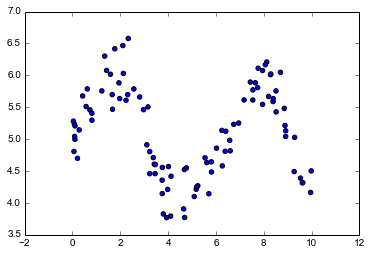

In [13]:
def produce_batch(batch_size, noise=0.3):
  xs = np.random.random(size=[batch_size, 1]) * 10
  ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
  return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(100)
x_test, y_test = produce_batch(100)
plt.scatter(x_train, y_train)

### Let's fit the model to the data

The user has to specify the loss function and the optimizer, and slim does the rest.
In particular,  the slim.learning.train function does the following:

- For each iteration, evaluate the train_op, which updates the parameters using the optimizer applied to the current minibatch. Also, update the global_step.
- Occasionally store the model checkpoint in the specified directory. This is useful in case your machine crashes  - then you can simply restart from the specified checkpoint.
- Occasionally write summaries to ???. These can be examined in tensorboard.

In [14]:
# Everytime we run training, we need to store the model checkpoint in a new directory,
# in case anything has changed.
import time
ts = time.time()
ckpt_dir = '/tmp/tf/regression_model/model{}'.format(ts) # Place to store the checkpoint.
print('Saving to {}'.format(ckpt_dir))

Saving to /tmp/tf/regression_model/model1471957940.55


In [15]:
def convert_data_to_tensors(x, y):
  input_tensor = tf.constant(x)
  input_tensor.set_shape([None, 1])
  output_tensor = tf.constant(y)
  output_tensor.set_shape([None, 1])
  return input_tensor, output_tensor

In [17]:
graph = tf.Graph() # new graph
with graph.as_default():
  input_node, output_node = convert_data_to_tensors(x_train, y_train)

  # Make the model.
  prediction_node, nodes = regression_model(input_node, is_training=True)
 
  # Add the loss function to the graph.
  loss_node = slim.losses.sum_of_squares(prediction_node, output_node)
  # The total loss is the uers's loss plus any regularization losses.
  total_loss_node = slim.losses.get_total_loss()

  # Create some summaries to visualize the training process:
  ## TODO: add summaries.py to 3p
  #slim.summaries.add_scalar_summary(total_loss, 'Total Loss', print_summary=True)
  
  # Specify the optimizer and create the train op:
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
  train_op_node = slim.learning.create_train_op(total_loss_node, optimizer) 

  # Run the training inside a session.
  final_loss = slim.learning.train(
    train_op_node,
    logdir=ckpt_dir,
    number_of_steps=500,
    save_summaries_secs=1)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

('Finished training. Last batch loss:', 0.45064953)
Checkpoint saved in /tmp/tf/regression_model/model1471957940.55


### Training with multiple loss functions.

Sometimes we have multiple objectives we want to simultaneously optimize.
In slim, it is easy to add more losses, as we show below. (We do not optimize the total loss in this example,
but we show how to compute it.)

In [31]:
graph = tf.Graph()  # Make a new graph
with graph.as_default():
    input_node, output_node = convert_data_to_tensors(x_train, y_train)
    prediction_node, nodes = regression_model(input_node, is_training=True)

    # Add multiple loss nodes.
    sum_of_squares_loss_node = slim.losses.sum_of_squares(prediction_node, output_node)
    absolute_difference_loss_node = slim.losses.absolute_difference(prediction_node, output_node)

    # The following two ways to compute the total loss are equivalent
    regularization_loss_node = tf.add_n(slim.losses.get_regularization_losses())
    total_loss1_node = sum_of_squares_loss_node + absolute_difference_loss_node + regularization_loss_node

    # Regularization Loss is included in the total loss by default.
    # This is good for training, but not for testing.
    total_loss2_node = slim.losses.get_total_loss(add_regularization_losses=True)
    
    init_node = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_node) # Will randomize the parameters.
        total_loss1, total_loss2 = sess.run([total_loss1_node, total_loss2_node])
        print('Total Loss1: %f' % total_loss1)
        print('Total Loss2: %f' % total_loss2)

        print('Regularization Losses:')
        for loss_node in slim.losses.get_regularization_losses():
            print(loss_node)

        print('Loss Functions:')
        for loss_node in slim.losses.get_losses():
            print(loss_node)

Total Loss1: 63.857437
Total Loss2: 63.857437
Regularization Losses:
Tensor("deep_regression/fc1/weights/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/fc2/weights/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/prediction/weights/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Loss Functions:
Tensor("sum_of_squares_loss/value:0", shape=(), dtype=float32)
Tensor("absolute_difference/value:0", shape=(), dtype=float32)


### Let's load the saved model and use it for prediction.

The predictive accuracy is not very good, because we used a small model,
and only trained for 500 steps, to keep the demo fast. 
Running for 5000 steps improves performance a lot.

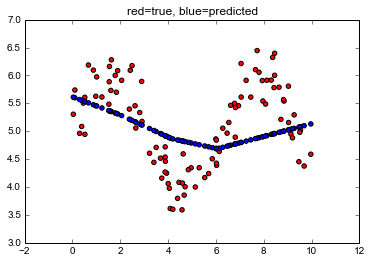

In [32]:
with tf.Graph().as_default():
    input_node, output_node = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    prediction_node, nodes = regression_model(input_node, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, true_outputs = sess.run([input_node, prediction_node, output_node])

plt.scatter(inputs, true_outputs, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

### Let's examine the learned parameters.

In [33]:
with tf.Graph().as_default():
    input_node = tf.placeholder(tf.float32, shape=(None, 1))
    output_node = tf.placeholder(tf.float32, shape=(None, 1))
    prediction_node, nodes = regression_model(input_node, is_training=False)
  
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        model_variables = slim.get_model_variables()
        for v in model_variables:
            val = sess.run(v)
            print v.name, val.shape, val


deep_regression/fc1/weights:0 (1, 10) [[ -5.06266467e-02   5.45447910e-13   1.21284246e-01  -1.44770980e-01
   -2.18129363e-02  -3.88705172e-02   1.23600796e-01  -1.58917261e-04
    5.34504652e-01   4.70542043e-01]]
deep_regression/fc1/biases:0 (10,) [ 0.51114881 -0.1092848   0.42604351  0.59958661  0.47088459  0.43627158
 -0.2441307  -0.09360857  0.20583071 -0.02956541]
deep_regression/fc2/weights:0 (10, 5) [[ -1.16052706e-11  -1.54837683e-01   5.02475441e-01   4.13749188e-01
   -4.51538116e-01]
 [ -6.81778906e-13   9.83630538e-12  -6.79897588e-12   3.31871358e-13
   -1.24219775e-11]
 [ -2.67401170e-02  -1.67030662e-01   1.13806441e-01  -3.86184417e-02
    2.97718614e-01]
 [  1.05787178e-12   2.26782888e-01   1.51686773e-01   1.58880055e-01
    1.96304187e-01]
 [ -3.65290524e-12   8.95788777e-04   6.14808314e-02   2.61927787e-02
    3.90173346e-02]
 [ -1.18928066e-12   8.73013437e-02  -8.43310803e-02   7.38054886e-02
    1.69781461e-01]
 [  3.83405853e-03  -2.50683814e-01   3.50693315

### Let's compute various evaluation metrics on the test set.

In slim termiology, losses are optimized, but metrics (which may not be differentiable, e.g., precision and recall) are just measured.
As an illustration, the code below computes mean squared error and mean absolute error metrics on the test set.

Each metric declaration creates several local variables (which must be initialized via tf.initialize_local_variables()) and returns both a value_op and an update_op. When evaluated, the value_op returns the current value of the metric. The update_op loads a new batch of data, runs the model, obtains the predictions and accumulates the metric statistics appropriately before returning the current value of the metric. We store these value nodes and update nodes in 2 dictionaries.

After creating the metric nodes, we can pass them to slim.evaluation.evaluation, which repeatedly evaluates these nodes the specified number of times. (This allows us to compute the evaluation in a streaming fashion across minibatches, which is usefulf for large datasets.) Finally, we print the final value of each metric.


In [34]:
with tf.Graph().as_default():
    input_node, output_node = convert_data_to_tensors(x_test, y_test)
    prediction_node, nodes = regression_model(input_node, is_training=False)

    # Specify metrics to evaluate:
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
      'Mean Squared Error': slim.metrics.streaming_mean_squared_error(prediction_node, output_node),
      'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(prediction_node, output_node)
    })


    init_node = tf.group(
        tf.initialize_all_variables(),
        tf.initialize_local_variables())

    # Make a session which restores the old graph parameters, and then run eval.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        metric_values = slim.evaluation.evaluation(
            sess,
            num_evals=1, # Single pass over data
            init_op=init_node,
            eval_op=names_to_update_nodes.values(),
            final_op=names_to_value_nodes.values())

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.iteritems():
      print('%s: %f' % (key, value))

Mean Squared Error: 23.741724
Mean Absolute Error: 4.810077


# Slim datasets
<a id='SlimData'></a>

A slim Dataset object contains a pointer to a data file, and metadata, so it knows how big the file is, what kind of data is stored in the file, etc. For example, some files contain images with labels, some also have bounding box annotations, etc. The Dataset object allows us to write generic code using the same API, regardless of the data format. 

The easiest way to create a slim Dataset is if the data is stored as a (possibly sharded)
[TFRecords file](https://www.tensorflow.org/versions/r0.10/how_tos/reading_data/index.html#file-formats), where each record contains a [tf.train.Example protocol buffer](https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/core/example/example.proto).
Slim uses a consistent convention for naming the keys and values inside each Example record. 

Once we have the data in TFRecord format, we can easily create a slim Dataset from it. Finally, we can create a slim DatasetDataProvider, which is an object which can "provide" minibatches of data on demand, using queue runners, to support high throughput parallel data processing. We illustrate this below.

For convenience, we include the following scripts to convert common image datasets into slim format:

<html>
<head>
<title>HTML Tables</title>
</head>
<body>
<table border="1">
<tr>
<td>Dataset</td>
<td>Download script</td>
<td>Dataset script</td>
<td>Contains</td>
</tr>
<tr>
<td><a href="https://github.com/tensorflow/models/tree/master/inception">Flowers</a></td>
<td><a href="https://github.com/tensorflow/models/blob/master/inception/inception/data/download_and_preprocess_flowers.sh">Script</a></td>
<td>TBD</td>
<td>~2500 color images of flowers, with 5 different labels.
</tr>
<tr>
<td><a href="http://yann.lecun.com/exdb/mnist/">MNIST</a></td>
<td><a href="https://cs.corp.google.com/piper///depot/google3/third_party/tensorflow_models/slim/datasets/download_and_convert_mnist.py">Script</a></td>
<td><a href="https://cs.corp.google.com/piper///depot/google3/third_party/tensorflow_models/slim/datasets/mnist.py">Script</a></td>
<td>60k+10k 28x28 grayscale images of handwritten digits, 10 class labels
</tr>
<tr>
<td><a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR-10</a></td>
<td><a href="https://cs.corp.google.com/piper///depot/google3/third_party/tensorflow_models/slim/datasets/download_and_convert_cifar10.py">Script</a></td>
<td><a href="https://cs.corp.google.com/piper///depot/google3/third_party/tensorflow_models/slim/datasets/cifar10.py">Script</a></td>
<td>50k+10k 32x32 color images, 10 class labels
</tr>
<tr>
<tr>
<td><a href="http://www.image-net.org/challenges/LSVRC/2012/index">ImageNet ILSVRC-2012-CLS</td>
<td><a href="https://github.com/tensorflow/models/blob/master/inception/inception/data/download_and_preprocess_imagenet.sh">Script</a></td>
<td><a href="https://cs.corp.google.com/piper///depot/google3/third_party/tensorflow_models/slim/datasets/imagenet.py">Script</a></td>
<td>1.2M color images, 1000 class labels
</tr>
<!--
<tr>
<td><a href="http://host.robots.ox.ac.uk/pascal/VOC/">Pascal VOC 2012</a></td>
<td>Script</td>
<td>Script</td>
<td>~20k color images, bounding boxes and class segmentation masks for 20 categories
</tr>
<tr>
<td><a href="http://mscoco.org/">MSCOCO</a></td>
<td>Script</td>
<td>Script</td>
<td>~120k color images, bounding boxes and instance segmentation masks for 80 categories, image captions from 5 raters, 16 keypoints for human pose
</tr>
-->
</table>
</body>
</html>


Below we give an example of using the small open source flowers dataset. 

### Download the TFRecord file.

To save time, we just download the testset, not all the data.

In [3]:
# Retrieve the data.
import six
import sys
from six.moves import urllib
import os
url = 'https://github.com/probml/pyprobml/blob/master/tensorflow/cifar10_test.tfrecord'
cifar10_folder = '/tmp/tf/cifar10'
filename = os.path.join(cifar10_folder, 'cifar10_test.tfrecord')
#urllib.request.urlretrieve(url, filename) # Corrupted?
cifar10_folder = '/tmp/cifar10' # Data put here using Nathan's script

### Convert TFRecord file to slim Dataset.

In [4]:
# %load https://raw.githubusercontent.com/probml/pyprobml/master/tensorflow/cifar10_make_slim_dataset.py
import tensorflow as tf

 
def make_cifar_dataset(split_name, tf_folder):
    """Make a dataset object from cifar10 tfrecord file.

    Args:
      split_name: "train" or "test"
      tf_folder: The base directory of the dataset sources.

    Returns:
      A `Dataset` namedtuple.

    Raises:
      ValueError: if `split_name` is not a valid train/test split.
    """
    SPLITS_TO_SIZES = {'train': 50000, 'test': 10000}

    ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [32 x 32 x 3] color image.',
        'label': 'A single integer between 0 and 9',
    }
    if split_name not in SPLITS_TO_SIZES:
        raise ValueError('split name %s was not recognized.' % split_name)

    file_pattern =  '%s/cifar10_%s.tfrecord' % (tf_folder, split_name)

    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
        'image/class/label': tf.FixedLenFeature(
            [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(shape=[32, 32, 3]),
        'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    decoder = slim.tfexample_decoder.TFExampleDecoder(
        keys_to_features, items_to_handlers)
   
    return slim.dataset.Dataset(
        data_sources=file_pattern,
        reader=tf.TFRecordReader,
        decoder=decoder,
        num_samples=SPLITS_TO_SIZES[split_name],
        items_to_descriptions=ITEMS_TO_DESCRIPTIONS)


### Display some of the data.

This dataset contains data of type ['image', 'label']


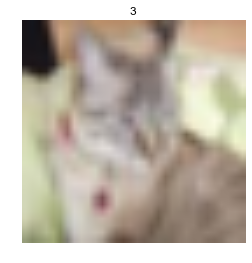

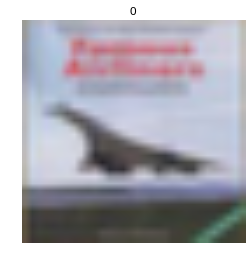

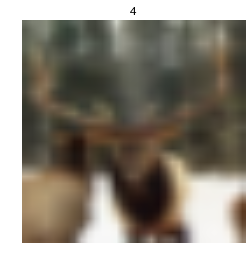

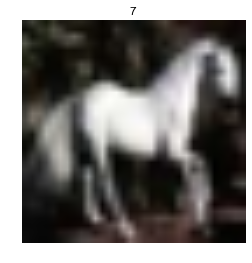

In [7]:
with tf.Graph().as_default(): 
    dataset = make_cifar_dataset('test', cifar10_folder) # Must make dataset in same graph as data_provider and model
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    print("This dataset contains data of type {}".format(data_provider.list_items()))
    
    image_node, label_node = data_provider.get(['image', 'label'])
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4):
                image, label = sess.run([image_node, label_node])
                plt.figure()
                plt.imshow(image)
                plt.title(label)
                plt.axis('off')
                plt.show()

# Convolutional neural nets (CNNs).
<a id='CNN'></a>

In this section, we show how to train an image classifier using a simple CNN.


### Define the model.

Note that the output layer is linear function. We will apply softmax transformation externally to the model.

In [5]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

### Apply the model to some random images.

In [6]:
with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is passed into the Model function.
    # All images must be the same size, because of the fully connected layers, which require a fixed size input.
    n_images = 3
    image_node = tf.random_uniform([n_images, 28, 28, 3], maxval=1)
    
    # Create the model.
    logits_node = my_cnn(image_node, 10, True)
    prob_node = tf.nn.softmax(logits_node)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.initialize_all_variables()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probs = sess.run(prob_node)
        
print(probs.shape)  # 3x10
print(probs)
print(np.sum(probs, 1)) # Each row sums to 1

(3, 10)
[[ 0.10661306  0.12116399  0.09892339  0.07751225  0.12889713  0.09552587
   0.08195546  0.12552176  0.09305233  0.07083475]
 [ 0.09924169  0.12025471  0.100233    0.0786428   0.13414718  0.09231888
   0.08684755  0.12540992  0.09094924  0.07195498]
 [ 0.10708407  0.1151024   0.09835725  0.07995781  0.1290087   0.09423116
   0.08455783  0.12923801  0.09116934  0.07129346]]
[ 1.          0.99999994  1.        ]


### Train the model on CIFAR10.

Make sure you run the code in the "Slim datasets" section first!

In [7]:
def preprocess(image, is_training):
    """Preprocesses the given image.

    Args:
        image: An image `Tensor` of size [32, 32, 3].
        is_training: A boolean, whether or not we're in training mode.

    Returns:
        A preprocessed and cropped image of shape [24, 24, 3]
    """
    height = 24
    width = 24

    if is_training:
        # Randomly crop a [height, width] section of the image.
        image = tf.random_crop(image, [height, width, 3])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)

        # Randomize the pixel values.
        image = tf.image.random_brightness(image, max_delta=63)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    else:
        # Crop the central [height, width] of the image.
        image = tf.image.resize_image_with_crop_or_pad(image, height, width)

    # Subtract off the mean and divide by the variance of the pixels.
    return tf.image.per_image_whitening(image)

In [8]:
def create_cifar_tensors(split_name='test'):
    dataset = make_cifar_dataset(split_name, cifar10_folder) 
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image, label = data_provider.get(['image', 'label'])
    
    # We have to use the preprocess function, otherwise we get this error:
    # TypeError: Expected uint8, got -0.059850560166457976 of type 'float' instead.
    image = preprocess(image, is_training=True)

    # Batch it up.
    images, labels = tf.train.batch(
          [image, label],
          batch_size=BATCH_SIZE,
          num_threads=2,
          capacity=10 * BATCH_SIZE)
    
    return images, labels

In [9]:
# Train the model on some labeled data.

CHECKPOINT_DIR = '/tmp/tf/cifar10_model/model{}'.format(time.time()) 
print('Saving model to {}'.format(CHECKPOINT_DIR))
BATCH_SIZE = 64
NUM_CLASSES = 10

with tf.Graph().as_default():
    # We train on the test set, just because it's smaller.
    images, labels = create_cifar_tensors('test')
  
    # Create the model:
    logits = my_cnn(images, num_classes=NUM_CLASSES, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, 10)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    # TODO: Make this be printed to stdout during training.
    tf.scalar_summary('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=CHECKPOINT_DIR,
      number_of_steps=50,
      save_summaries_secs=1)
  
    print('Finished training. Last batch loss {}'.format(final_loss))

NameError: name 'time' is not defined

### Evaluate some metrics.

As we discussed above, we can compute various metrics besides the loss.
Below we show how to compute prediction accuracy of the trained model, as well as top-5 classification accuracy. (The difference between evaluation and evaluation_loop is that the latter writes the results to a log directory, so they can be viewed in tensorboard.)

In [44]:
import math
BATCH_SIZE = 64
EVAL_DIR = CHECKPOINT_DIR
NUM_TEST_IMAGES = 10000

with tf.Graph().as_default():
    images, labels = create_cifar_tensors('test')
    logits = my_cnn(images, num_classes=NUM_CLASSES, is_training=False)
    predictions = tf.argmax(logits, 1)

    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
    })
    
    # Create the summary ops such that they also print out to std output:
    summary_ops = []
    for name, value in names_to_values.iteritems():
        op = tf.scalar_summary(name, value, collections=[])
        op = tf.Print(op, [value], name)
        tf.add_to_collection(tf.GraphKeys.SUMMARIES, op)
        summary_ops.append(op)

    
    # This ensures that we make a single pass over all of the data.
    # TODO: How to handle case where test size is not integer multiple of batch size?
    num_batches = math.ceil(NUM_TEST_IMAGES / float(BATCH_SIZE))

    print('Running evaluation Loop...')
    
    slim.evaluation.evaluation_loop(
        master='',
        checkpoint_dir=CHECKPOINT_DIR,  # Restores model from this checkpoint.
        logdir=EVAL_DIR,
        num_evals=num_batches,
        eval_op=names_to_updates.values(),
        summary_op=tf.merge_summary(summary_ops),
        max_number_of_evaluations=1, # Only run loop once
        eval_interval_secs=1)
    print('Done!')
    
# To print the eval, we need to use tensorboard to decode the files in EVAL_DIR...
# TODO: Make this print to screen while running.

Running evaluation Loop...
Done!


### Apply the model to some test images.

In [45]:
with tf.Graph().as_default():
    # Use random images. They must be the same size as the preprocessed training set, because we are restoring
    # fully connected layers from the checkpoint.
    n_images = 5
    image_node = tf.random_uniform([n_images, 24, 24, 3], maxval=1)
  
    # Create the model structure. (Parameters will be loaded below.)
    logits_node = my_cnn(image_node, num_classes=NUM_CLASSES, is_training=False)
    prob_node = tf.nn.softmax(logits_node)
    
    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=CHECKPOINT_DIR)
    with sv.managed_session() as sess:
        probs = sess.run(prob_node)

print(probs.shape)  # 5x10
print(probs)
print(np.sum(probs, 1)) # Each row sums to 1

(5, 10)
[[ 0.10011527  0.09608188  0.10562347  0.09711935  0.09762073  0.10073517
   0.09946882  0.09867113  0.10392854  0.10063568]
 [ 0.10011527  0.09608188  0.10562347  0.09711935  0.09762073  0.10073517
   0.09946882  0.09867113  0.10392854  0.10063568]
 [ 0.10011527  0.09608188  0.10562347  0.09711935  0.09762073  0.10073517
   0.09946882  0.09867113  0.10392854  0.10063568]
 [ 0.10011527  0.09608188  0.10562347  0.09711935  0.09762073  0.10073517
   0.09946882  0.09867113  0.10392854  0.10063568]
 [ 0.10011527  0.09608188  0.10562347  0.09711935  0.09762073  0.10073517
   0.09946882  0.09867113  0.10392854  0.10063568]]
[ 1.  1.  1.  1.  1.]


# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models. In particular, you can download the following pre-trained CNNs for image classification, all trained on [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/index), which has ~1.2M with 1000 mutually exclusive class labels (top 1% accuracy on validation set in final column):

<html>
<body>
<table border="1">
<tr>
<td>Model</td>
<td>Slim file</td>
<td>Checkpoint</td>
<td>Accuracy</td?
</tr>
<tr>
<td><a href="http://www.robots.ox.ac.uk/~vgg/research/very_deep/">VGG-16</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/vgg.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/vgg_16.tar.gz">File</a></td>
<td>71.0</td>
</tr>
<tr>
<td><a href="http://www.robots.ox.ac.uk/~vgg/research/very_deep/">VGG-19</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/vgg.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/vgg_19.tar.gz">File</a></td>
<td>?</td>
</tr>
<tr>
<td><a href="https://arxiv.org/abs/1409.4842">Inception-v1</a></td>
<td><a href="
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/inception_v1.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/inception_v1.tar.gz">File</a></td>
<td>69.8</td>
</tr>
<tr>
<td><a href="http://arxiv.org/abs/1502.03167">Inception-v2</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/inception-v2.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/inception_v2.tar.gz">File</a></td>
<td>73.9</td>
</tr>
<tr>
<td><a href="http://arxiv.org/abs/1512.00567">Inception-v3</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/inception-v3.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/inception_v3.tar.gz">File</a></td>
<td>78.0</td>
</tr>
<!--
<tr>
<td><a href="https://arxiv.org/abs/1602.07261">Inception-Resnet-v2</a></td>
<td>Coming soon</td>
<td>Coming soon</td>
</tr>
-->
<tr>
<td><a href="https://arxiv.org/abs/1512.03385">Resnet-v1-50</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/resnet_v1.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/resnet_v1_50.tar.gz">File</a></td>
<td>75.2</td>
</tr>
<tr>
<td><a href="https://arxiv.org/abs/1512.03385">Resnet-v1-101</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/resnet_v1.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/resnet_v1_101.tar.gz">File</a></td>
<td>76.4</td>
</tr>
<!--
<tr>
<td><a href="https://arxiv.org/abs/1603.05027">Resnet-v2-101</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/resnet_v2.py">File</a></td>
<td>Coming soon</td>
</tr>
-->
<tr>
<td><a href="https://arxiv.org/abs/1512.03385">Resnet-v1-152</a></td>
<td><a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/nets/resnet_v1.py">File</a></td>
<td><a href="http://download.tensorflow.org/models/resnet_v1_152.tar.gz">File</a></td>
<td>76.8</td>
</tr>
</table>
</body>
</html>


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v3 as the base model.


### Download inception checkpoint.

The checkpoint just contains the parameters, not the model structure, so we need to know which python function was used to create the model. The checkpoint and the model spec file must use the same layer names, etc.

In [3]:
import six
import sys
from six.moves import urllib
import os
import tarfile

#url = 'http://download.tensorflow.org/models/image/imagenet/inception-v3-2016-03-01.tar.gz'
url = "http://download.tensorflow.org/models/inception_v3.tar.gz"
inception_folder = '/tmp/tf/inception-v3'
if not os.path.exists(inception_folder):
    os.mkdir(inception_folder)
filename = url.split('/')[-1]
filepath = os.path.join(inception_folder, filename)
if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
        sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,
            float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(url, filepath, _progress)
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(inception_folder)

>> Downloading inception_v3.tar.gz 100.0%('Successfully downloaded', 'inception_v3.tar.gz', 100884956, 'bytes.')


### Apply pretrained model to some images.

In [11]:
import tensorflow.contrib.slim.nets as nets
with tf.Graph().as_default():
    # Create data source
    #image_node = tf.ones((32, 224, 224, 3))
    dataset = make_cifar_dataset('test', cifar10_folder) 
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image_node, label_node = data_provider.get(['image', 'label'])
    # Create model. 
    scope = nets.inception.inception_v3_arg_scope(is_training=True)
    with slim.arg_scope(scope):
        logits_node, layer_nodes = nets.inception.inception_v3(image_node, num_classes=10)
    # Apply model to data
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4):
                image, label = sess.run([image_node, label_node])
                logits = sess.run([logits_node])
                predicted_label = np.argmax(logits)
                plt.figure()
                plt.subplot(1, 1, i)
                plt.imshow(image)
                plt.title('true label {}, predicted {}'.format(label, predicted_label))
                plt.axis('off')
                plt.show()

ValueError: rank of shape must be at least 4 not: 3

### Fine-tune the model on a different set of labels.
